## The goal of this notebook is to figure out which features are most indicative of a sucessful email.

# 1/ Data Processing

There was a problem reading the last column in panda so I loaded it into Excel and manually deleted the column tags, since in my opinion it is not helpful.

Let's load the data and see what does it look like

In [78]:
import pandas as pd
df = pd.read_csv('sequence-mailings.csv')
df.head()

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (2,27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,message_id,parent_message_id,to_domain,from,is_thread_reply,subject_customized,body_customized,subject_length,body_length,...,prospect_opted_out,persona,company_name,company_size,industry,website,company_locality,company_tier,sequence_order,Unnamed: 43
0,6756,<541c38a863c25_5ad93fae6971f12c_1_67@app.mail>,NaN,birchbox.com,manny@outreach.io,1,0,0,33.0,850.0,...,NaN,Recruiting,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
1,6757,<541c530d33a3e_38983f994f693278_1_e4@worker.mail>,NaN,birchbox.com,manny@outreach.io,1,0,0,NaN,249.0,...,NaN,Recruiting,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN
2,6762,<541cc6885b944_6f803f8c38c7514c_1_63@app.mail>,NaN,customerlobby.com,manny@outreach.io,1,0,0,19.0,1012.0,...,NaN,Sales Leadership,Customer Lobby,51.0,Internet,customerlobby.com,Berkeley,Mid-Market,1,NaN
3,6763,<541cc68876a28_6f803f8c38c7514c_1_3b@app.mail>,NaN,doubledutch.me,manny@outreach.io,1,0,0,19.0,1012.0,...,NaN,Sales Leadership,DoubleDutch,51.0,Computer Software,www.doubledutch.me,San Francisco,Mid-Market,1,NaN
4,6764,<541cc6888fc74_6f803f8c38c7514c_1_35@app.mail>,NaN,maprtech.com,manny@outreach.io,1,0,0,19.0,1012.0,...,12/12/14 15:10,Sales Leadership,MapR Technologies,NaN,NaN,NaN,NaN,NaN,1,NaN


In [11]:
df.shape

(1023321, 44)

We have more than 1 million observations and three potential response variables

In [98]:
response = ['replied_at','clicked_at','opened_at']

So we have 41 potential predictors. That's not a big number so I will examine each feature individually. 

Based on the description provided and my own judgement, these features are likely to be irrelevant or there are other features in the dataset that provide idential or better information. Thus these features will be dropped. The list also includes features that have more than 50% missing values since these features are unlikely to contain any predictive information.

To improve readability, I have omitted the code in which I examine these features

In [35]:
drop = ['id','message_id','from','thread_replied_at','prospect_id','prospect_first_name','prospect_time_zone',
       'prospect_gender','prospect_dob','prospect_zip','prospect_website','prospect_opted_out','to_domain',
        'company_size','website','company_locality','parent_message_id','mailbox_id','template_id','sequence_id',
        'sequence_step_id','sequence_template_id','sequence_state_id','company_name']
df = df.drop(columns=drop)

I included 'from' in the list above because I think our purpose is not to evaluate the performance of our sale team. 'parent_message_id' is also in the list because the three potential response variables contain so many NULL values  that makes it impossible to use those variables of the parents to help predicting the children's output. I also feel like all of those ids are more for internal usage and decide not to use them in making predictions.

Next I modify the data a little and do some feature engineering

In [79]:
# Convert the three potential response variables to binary
df['opened'] = df['opened_at'].apply(lambda x: 0 if pd.isna(x) else 1)
df['clicked'] = df['clicked_at'].apply(lambda x: 0 if pd.isna(x) else 1)
df['replied'] = df['replied_at'].apply(lambda x: 0 if pd.isna(x) else 1)

In [37]:
# Convert NULL in 'includes_link' to 0
df['includes_link'] = df['includes_link'].apply(lambda x: x if x==1 else 0)

In [38]:
# Feature engineering for 'delivered_at' by converting it to date, month, date of the week, time interval (length 3-hour each)
from datetime import datetime
import numpy as np
df['delivered_time'] = df['delivered_at'].apply(lambda x: int(x.split()[1].split(":")[0]))
df['delivered_time_interval'] = np.where(df['delivered_time']<3, 1, np.where(df['delivered_time']<6,2,
                                        np.where(df['delivered_time']<9,3,np.where(df['delivered_time']<12,4,
                                        np.where(df['delivered_time']<15,5,np.where(df['delivered_time']<18,6,
                                        np.where(df['delivered_time']<21,7,8)))))))
df['delivered_month'] = df['delivered_at'].apply(lambda x: x.split('/')[0])
df['delivered_date'] = df['delivered_at'].apply(lambda x: x.split('/')[1])
df['delivered_weekdate'] = df['delivered_at'].apply(lambda x: datetime.strptime(x.split()[0], '%m/%d/%y').weekday())


In [39]:
# List of categorical predictors:
cat = ['prospect_occupation','prospect_city','prospect_country','persona','industry','company_tier',
      'delivered_time_interval','delivered_month','delivered_date','delivered_weekdate']

# We have quite a few categorical features but we have 1 millions observations so let's keep all these features for now.

In [40]:
# Now we can further remove all the remaining useless variables
drop2 = ['delivered_at', 'replied_at','opened_at','clicked_at','Unnamed: 43','delivered_time']
df = df.drop(columns=drop2)

In [286]:
df.head()

,is_thread_reply,subject_customized,body_customized,subject_length,body_length,track_links,track_opens,includes_link,prospect_occupation,prospect_city,...,industry,company_tier,sequence_order,opened,clicked,replied,delivered_time_interval,delivered_month,delivered_date,delivered_weekdate
0,1,0,0,33.0,850.0,0.0,1.0,0.0,NaN,NaN,...,NaN,NaN,1,1,0,0,6,9,19,4
1,1,0,0,NaN,249.0,1.0,1.0,0.0,NaN,NaN,...,NaN,NaN,2,1,0,0,6,9,22,0
2,1,0,0,19.0,1012.0,1.0,1.0,0.0,Internet,Berkeley,...,Internet,Mid-Market,1,0,0,0,1,9,20,5
3,1,0,0,19.0,1012.0,1.0,1.0,0.0,Computer Software,San Francisco,...,Computer Software,Mid-Market,1,1,0,0,1,9,20,5
4,1,0,0,19.0,1012.0,1.0,1.0,0.0,NaN,NaN,...,NaN,NaN,1,1,0,0,1,9,20,5


# 2/ Exploratory Data Analysis

We now explore the potential response 

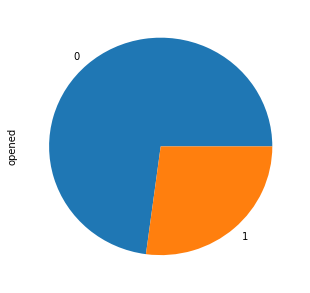

In [135]:
# Pie chart for open
df.opened.value_counts().plot(kind='pie',figsize=(5, 5))

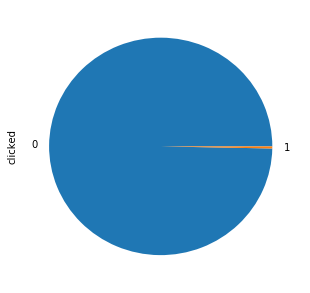

In [138]:
# Pie chart for click
df.clicked.value_counts().plot(kind='pie',figsize=(5, 5))

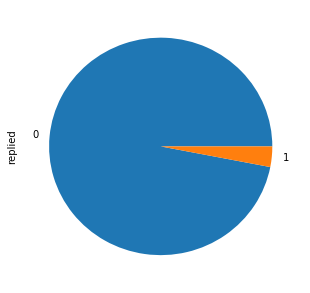

In [139]:
# Pie chart for reply
df.replied.value_counts().plot(kind='pie',figsize=(5, 5))

We can see that while there are a handleful of opened emails in our dataset, the portions of clicked and replied are extremely small. This suggest that the data is highly unbalanced and some sampling techniques need to be applied.

Among the features we have, there are a few I would like to take a closer look

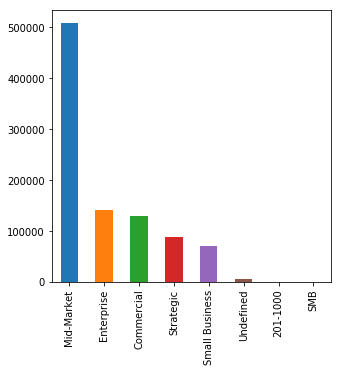

In [141]:
# bar chart for company_tier
df.company_tier.value_counts().plot(kind='bar',figsize=(5, 5))

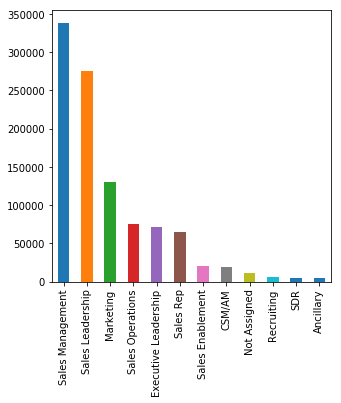

In [142]:
# bar chart for persona
df.persona.value_counts().plot(kind='bar',figsize=(5, 5))

For the next 2 heat map, vertical axis is time interval (starting from midnight, each interval is 3 hours),
horizontal axis is date of the week (starting from Monday).

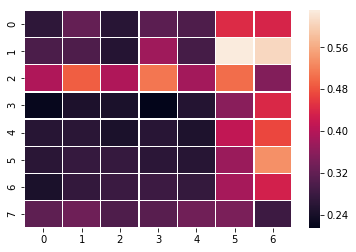

In [164]:
# Heat map for opened ratio, 
import matplotlib.pyplot as plt
import seaborn as sns
open_avg = np.array(df[['opened','delivered_time_interval', 'delivered_weekdate']].groupby(['delivered_time_interval', 'delivered_weekdate']).agg([ 'mean']).unstack())
ax = sns.heatmap(open_avg, linewidth=0.5)
plt.show()

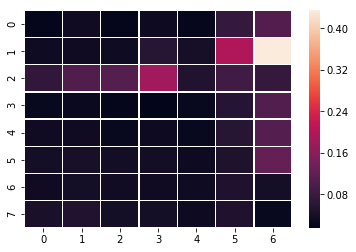

In [165]:
# Heat map for replied ratio
replied_avg = np.array(df[['replied','delivered_time_interval', 'delivered_weekdate']].groupby(['delivered_time_interval', 'delivered_weekdate']).agg([ 'mean']).unstack())
ax = sns.heatmap(replied_avg, linewidth=0.5)
plt.show()

Looking at both heat maps we can see that emails sent in the third interval (6-9am) seem to have the most success. Prospectes are also more likely to open the emails sent from 9pm until midnight. These time intervals make sense since people tend to deal with emails at the beginning or the end of the day. 

In terms of sucess rate difference between dates of the week, there is not much difference in the replied ratio except a moderate improvement Sunday. However, we can observe a significant increase in the opend ratio on weekend. This finding suggests that maybe sending out emails on weekend may be a good idea. 

Let's do some modeling and formal testing to verify these observations.

# 3/ Model fitting

In this section I will take a machine learning approach in determining which features are indicative of successful emails.

For now I assume that a successful email is the one which is either replied or clicked ('include_link' must be True)
since these two actions represent interaction/response from the recipient. Otherwise an email is defined to be unsuccessful.

In [80]:
df['success'] = np.where(df['replied']==1,1,np.where((df['clicked']==1) & (df['includes_link']==1),1,0))

In [187]:
# The data is very imbalanced and thus we need to do undersampling to train our models on balanced data
df['success'].value_counts()

0    992182
1     31139
Name: success, dtype: int64

In [213]:
# Adjust the dataset
df=df.reset_index()
for col in cat:
    df[col] = df[col].astype('category')

# Undersampling for negative class
pos = df[df.success==1]
neg = df[df.success==0].sample(n=31139, random_state=1)
useddf = pos.append(neg)

X = useddf[['index','is_thread_reply', 'subject_customized', 'body_customized',
       'subject_length', 'body_length', 'track_links', 'track_opens',
        'prospect_occupation', 'prospect_city',
       'prospect_country', 'persona',  'industry',
       'company_tier', 'sequence_order',
       'delivered_time_interval', 'delivered_month', 'delivered_date',
       'delivered_weekdate']]
y=useddf['success']

# Train/Validation/Test split
from sklearn.model_selection import train_test_split
X_train, _, y_train, _ = train_test_split(X, y, test_size=0.15, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.175, random_state=1)

# Save the training+validation indices so that we do not test these cases in the testing phase
used_index = X_train.index.append(X_val.index)
X_train=X_train.drop(columns='index')
X_val=X_val.drop(columns='index')

# The test set will be all emails that are not in the training and validation set
test = df[~df.index.isin(used_index)]

a) Baseline model will be decision tree since it is straightfoward, fast to fit and can handle missing value

In [226]:
# I use the validation set to tune tree depth
deep = [3,5,7,9,11,-1]
for d in deep:
    parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'boosting': 'gbdt',
    'feature_fraction': 1,
    'learning_rate': 1,
    'verbose': 0,
    'num_iterations':1,
    'max_depth':d
    }

    tree = lgb.train(parameters,train_data,valid_sets=val_data)

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's auc: 0.684663
[1]	valid_0's auc: 0.713991
[1]	valid_0's auc: 0.722789
[1]	valid_0's auc: 0.721739
[1]	valid_0's auc: 0.721739
[1]	valid_0's auc: 0.721739


In [228]:
# Fit a final tree with depth=7
parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'boosting': 'gbdt',
    'feature_fraction': 1,
    'learning_rate': 1,
    'verbose': 0,
    'num_iterations':1,
    'max_depth':7
    }

final_tree = lgb.train(parameters,train_data,valid_sets=val_data)

[1]	valid_0's auc: 0.722789


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [250]:
# Evaluate on test set
from sklearn.metrics import confusion_matrix
confusion_matrix(test.success,np.round(final_tree.predict(test)))

array([[519217, 446434],
       [  2776,   1958]])

We have a lot of false negatives. Let's see how the Gradient boosting can do better

b) Now we build a more advanced model to see whether we can improve the performance. The model I choose is Gradient Boosting

In [256]:
# I am not a big fan of tuning so I will only build one big model in LightGBM
parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'boosting': 'dart',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0,
    'min_data_in_leaf':value
    }    

gbm = lgb.train(parameters,
                       train_data,
                       valid_sets=val_data,
                       num_boost_round=5000,
                       early_stopping_rounds=100)

[1]	valid_0's auc: 0.690523
[2]	valid_0's auc: 0.694646
[3]	valid_0's auc: 0.687904
[4]	valid_0's auc: 0.690012
[5]	valid_0's auc: 0.710961
[6]	valid_0's auc: 0.718237
[7]	valid_0's auc: 0.71812
[8]	valid_0's auc: 0.720011
[9]	valid_0's auc: 0.725231
[10]	valid_0's auc: 0.724033
[11]	valid_0's auc: 0.720515
[12]	valid_0's auc: 0.721199
[13]	valid_0's auc: 0.727704
[14]	valid_0's auc: 0.725242
[15]	valid_0's auc: 0.726512
[16]	valid_0's auc: 0.729763
[17]	valid_0's auc: 0.734668
[18]	valid_0's auc: 0.733594
[19]	valid_0's auc: 0.73479
[20]	valid_0's auc: 0.734626
[21]	valid_0's auc: 0.734503
[22]	valid_0's auc: 0.735338


/anaconda3/lib/python3.6/site-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[23]	valid_0's auc: 0.738332
[24]	valid_0's auc: 0.738119
[25]	valid_0's auc: 0.740087
[26]	valid_0's auc: 0.73966
[27]	valid_0's auc: 0.740898
[28]	valid_0's auc: 0.740596
[29]	valid_0's auc: 0.741593
[30]	valid_0's auc: 0.741494
[31]	valid_0's auc: 0.74097
[32]	valid_0's auc: 0.740964
[33]	valid_0's auc: 0.741197
[34]	valid_0's auc: 0.741133
[35]	valid_0's auc: 0.740803
[36]	valid_0's auc: 0.740862
[37]	valid_0's auc: 0.740836
[38]	valid_0's auc: 0.742183
[39]	valid_0's auc: 0.742206
[40]	valid_0's auc: 0.74259
[41]	valid_0's auc: 0.742587
[42]	valid_0's auc: 0.744401
[43]	valid_0's auc: 0.744317
[44]	valid_0's auc: 0.745166
[45]	valid_0's auc: 0.744647
[46]	valid_0's auc: 0.744879
[47]	valid_0's auc: 0.745455
[48]	valid_0's auc: 0.745725
[49]	valid_0's auc: 0.745757
[50]	valid_0's auc: 0.745583
[51]	valid_0's auc: 0.745249
[52]	valid_0's auc: 0.745074
[53]	valid_0's auc: 0.745086
[54]	valid_0's auc: 0.745213
[55]	valid_0's auc: 0.745997
[56]	valid_0's auc: 0.746106
[57]	valid_0's au

[300]	valid_0's auc: 0.754785
[301]	valid_0's auc: 0.754819
[302]	valid_0's auc: 0.755211
[303]	valid_0's auc: 0.755188
[304]	valid_0's auc: 0.755214
[305]	valid_0's auc: 0.755218
[306]	valid_0's auc: 0.755246
[307]	valid_0's auc: 0.755294
[308]	valid_0's auc: 0.755414
[309]	valid_0's auc: 0.755464
[310]	valid_0's auc: 0.7554
[311]	valid_0's auc: 0.755442
[312]	valid_0's auc: 0.755393
[313]	valid_0's auc: 0.755473
[314]	valid_0's auc: 0.755497
[315]	valid_0's auc: 0.755523
[316]	valid_0's auc: 0.755421
[317]	valid_0's auc: 0.755415
[318]	valid_0's auc: 0.75535
[319]	valid_0's auc: 0.755376
[320]	valid_0's auc: 0.755378
[321]	valid_0's auc: 0.755383
[322]	valid_0's auc: 0.755738
[323]	valid_0's auc: 0.75612
[324]	valid_0's auc: 0.756122
[325]	valid_0's auc: 0.756068
[326]	valid_0's auc: 0.756068
[327]	valid_0's auc: 0.756098
[328]	valid_0's auc: 0.756103
[329]	valid_0's auc: 0.756097
[330]	valid_0's auc: 0.756091
[331]	valid_0's auc: 0.756084
[332]	valid_0's auc: 0.756103
[333]	valid_0'

[576]	valid_0's auc: 0.759636
[577]	valid_0's auc: 0.759634
[578]	valid_0's auc: 0.759633
[579]	valid_0's auc: 0.759648
[580]	valid_0's auc: 0.759624
[581]	valid_0's auc: 0.759475
[582]	valid_0's auc: 0.759494
[583]	valid_0's auc: 0.75953
[584]	valid_0's auc: 0.75955
[585]	valid_0's auc: 0.759684
[586]	valid_0's auc: 0.759685
[587]	valid_0's auc: 0.759635
[588]	valid_0's auc: 0.759643
[589]	valid_0's auc: 0.759645
[590]	valid_0's auc: 0.75966
[591]	valid_0's auc: 0.759644
[592]	valid_0's auc: 0.759645
[593]	valid_0's auc: 0.759439
[594]	valid_0's auc: 0.759421
[595]	valid_0's auc: 0.759405
[596]	valid_0's auc: 0.759375
[597]	valid_0's auc: 0.759367
[598]	valid_0's auc: 0.75937
[599]	valid_0's auc: 0.759453
[600]	valid_0's auc: 0.759454
[601]	valid_0's auc: 0.759581
[602]	valid_0's auc: 0.759582
[603]	valid_0's auc: 0.759691
[604]	valid_0's auc: 0.759654
[605]	valid_0's auc: 0.759652
[606]	valid_0's auc: 0.759649
[607]	valid_0's auc: 0.759651
[608]	valid_0's auc: 0.760144
[609]	valid_0'

[850]	valid_0's auc: 0.761788
[851]	valid_0's auc: 0.761779
[852]	valid_0's auc: 0.761746
[853]	valid_0's auc: 0.761717
[854]	valid_0's auc: 0.761715
[855]	valid_0's auc: 0.761798
[856]	valid_0's auc: 0.761911
[857]	valid_0's auc: 0.761908
[858]	valid_0's auc: 0.761913
[859]	valid_0's auc: 0.761916
[860]	valid_0's auc: 0.761915
[861]	valid_0's auc: 0.761972
[862]	valid_0's auc: 0.761987
[863]	valid_0's auc: 0.761991
[864]	valid_0's auc: 0.761981
[865]	valid_0's auc: 0.762093
[866]	valid_0's auc: 0.762107
[867]	valid_0's auc: 0.762092
[868]	valid_0's auc: 0.762092
[869]	valid_0's auc: 0.762092
[870]	valid_0's auc: 0.762081
[871]	valid_0's auc: 0.762076
[872]	valid_0's auc: 0.76215
[873]	valid_0's auc: 0.762135
[874]	valid_0's auc: 0.762133
[875]	valid_0's auc: 0.762139
[876]	valid_0's auc: 0.762251
[877]	valid_0's auc: 0.762256
[878]	valid_0's auc: 0.762259
[879]	valid_0's auc: 0.762263
[880]	valid_0's auc: 0.762266
[881]	valid_0's auc: 0.762261
[882]	valid_0's auc: 0.762382
[883]	valid

[1120]	valid_0's auc: 0.762515
[1121]	valid_0's auc: 0.76247
[1122]	valid_0's auc: 0.762502
[1123]	valid_0's auc: 0.762589
[1124]	valid_0's auc: 0.762597
[1125]	valid_0's auc: 0.762507
[1126]	valid_0's auc: 0.762511
[1127]	valid_0's auc: 0.762508
[1128]	valid_0's auc: 0.762509
[1129]	valid_0's auc: 0.762649
[1130]	valid_0's auc: 0.762639
[1131]	valid_0's auc: 0.762631
[1132]	valid_0's auc: 0.762702
[1133]	valid_0's auc: 0.762566
[1134]	valid_0's auc: 0.762688
[1135]	valid_0's auc: 0.762535
[1136]	valid_0's auc: 0.762537
[1137]	valid_0's auc: 0.76252
[1138]	valid_0's auc: 0.762515
[1139]	valid_0's auc: 0.76251
[1140]	valid_0's auc: 0.762541
[1141]	valid_0's auc: 0.762549
[1142]	valid_0's auc: 0.762539
[1143]	valid_0's auc: 0.76254
[1144]	valid_0's auc: 0.762553
[1145]	valid_0's auc: 0.762554
[1146]	valid_0's auc: 0.762543
[1147]	valid_0's auc: 0.762539
[1148]	valid_0's auc: 0.762538
[1149]	valid_0's auc: 0.762661
[1150]	valid_0's auc: 0.762656
[1151]	valid_0's auc: 0.762648
[1152]	valid

[1386]	valid_0's auc: 0.761559
[1387]	valid_0's auc: 0.761573
[1388]	valid_0's auc: 0.761516
[1389]	valid_0's auc: 0.761515
[1390]	valid_0's auc: 0.76146
[1391]	valid_0's auc: 0.761456
[1392]	valid_0's auc: 0.761457
[1393]	valid_0's auc: 0.761433
[1394]	valid_0's auc: 0.761423
[1395]	valid_0's auc: 0.761639
[1396]	valid_0's auc: 0.761636
[1397]	valid_0's auc: 0.761688
[1398]	valid_0's auc: 0.761694
[1399]	valid_0's auc: 0.761685
[1400]	valid_0's auc: 0.761716
[1401]	valid_0's auc: 0.761716
[1402]	valid_0's auc: 0.761709
[1403]	valid_0's auc: 0.761664
[1404]	valid_0's auc: 0.761664
[1405]	valid_0's auc: 0.761646
[1406]	valid_0's auc: 0.761654
[1407]	valid_0's auc: 0.761666
[1408]	valid_0's auc: 0.76166
[1409]	valid_0's auc: 0.761627
[1410]	valid_0's auc: 0.761623
[1411]	valid_0's auc: 0.761625
[1412]	valid_0's auc: 0.761707
[1413]	valid_0's auc: 0.761739
[1414]	valid_0's auc: 0.761737
[1415]	valid_0's auc: 0.761732
[1416]	valid_0's auc: 0.76164
[1417]	valid_0's auc: 0.761637
[1418]	vali

[1652]	valid_0's auc: 0.761466
[1653]	valid_0's auc: 0.761775
[1654]	valid_0's auc: 0.761643
[1655]	valid_0's auc: 0.761638
[1656]	valid_0's auc: 0.761604
[1657]	valid_0's auc: 0.761598
[1658]	valid_0's auc: 0.761727
[1659]	valid_0's auc: 0.761711
[1660]	valid_0's auc: 0.761701
[1661]	valid_0's auc: 0.761695
[1662]	valid_0's auc: 0.761678
[1663]	valid_0's auc: 0.761602
[1664]	valid_0's auc: 0.761571
[1665]	valid_0's auc: 0.761563
[1666]	valid_0's auc: 0.761556
[1667]	valid_0's auc: 0.761584
[1668]	valid_0's auc: 0.761572
[1669]	valid_0's auc: 0.761572
[1670]	valid_0's auc: 0.761508
[1671]	valid_0's auc: 0.761542
[1672]	valid_0's auc: 0.761529
[1673]	valid_0's auc: 0.761515
[1674]	valid_0's auc: 0.761503
[1675]	valid_0's auc: 0.761441
[1676]	valid_0's auc: 0.761357
[1677]	valid_0's auc: 0.761501
[1678]	valid_0's auc: 0.761528
[1679]	valid_0's auc: 0.761476
[1680]	valid_0's auc: 0.761493
[1681]	valid_0's auc: 0.761522
[1682]	valid_0's auc: 0.761505
[1683]	valid_0's auc: 0.761514
[1684]	v

[1919]	valid_0's auc: 0.761453
[1920]	valid_0's auc: 0.761438
[1921]	valid_0's auc: 0.761433
[1922]	valid_0's auc: 0.761436
[1923]	valid_0's auc: 0.761472
[1924]	valid_0's auc: 0.761468
[1925]	valid_0's auc: 0.761468
[1926]	valid_0's auc: 0.7615
[1927]	valid_0's auc: 0.761504
[1928]	valid_0's auc: 0.761497
[1929]	valid_0's auc: 0.761497
[1930]	valid_0's auc: 0.761531
[1931]	valid_0's auc: 0.761568
[1932]	valid_0's auc: 0.76158
[1933]	valid_0's auc: 0.761573
[1934]	valid_0's auc: 0.761642
[1935]	valid_0's auc: 0.76163
[1936]	valid_0's auc: 0.761661
[1937]	valid_0's auc: 0.761657
[1938]	valid_0's auc: 0.761726
[1939]	valid_0's auc: 0.761676
[1940]	valid_0's auc: 0.761663
[1941]	valid_0's auc: 0.761673
[1942]	valid_0's auc: 0.76183
[1943]	valid_0's auc: 0.761846
[1944]	valid_0's auc: 0.761932
[1945]	valid_0's auc: 0.76194
[1946]	valid_0's auc: 0.761934
[1947]	valid_0's auc: 0.761933
[1948]	valid_0's auc: 0.761936
[1949]	valid_0's auc: 0.762069
[1950]	valid_0's auc: 0.762218
[1951]	valid_0

[2185]	valid_0's auc: 0.76288
[2186]	valid_0's auc: 0.762878
[2187]	valid_0's auc: 0.762899
[2188]	valid_0's auc: 0.762898
[2189]	valid_0's auc: 0.762759
[2190]	valid_0's auc: 0.762755
[2191]	valid_0's auc: 0.76287
[2192]	valid_0's auc: 0.762855
[2193]	valid_0's auc: 0.762824
[2194]	valid_0's auc: 0.762849
[2195]	valid_0's auc: 0.762784
[2196]	valid_0's auc: 0.762784
[2197]	valid_0's auc: 0.762779
[2198]	valid_0's auc: 0.762685
[2199]	valid_0's auc: 0.762592
[2200]	valid_0's auc: 0.762512
[2201]	valid_0's auc: 0.762499
[2202]	valid_0's auc: 0.762493
[2203]	valid_0's auc: 0.762485
[2204]	valid_0's auc: 0.762487
[2205]	valid_0's auc: 0.762486
[2206]	valid_0's auc: 0.762463
[2207]	valid_0's auc: 0.762461
[2208]	valid_0's auc: 0.76245
[2209]	valid_0's auc: 0.762348
[2210]	valid_0's auc: 0.762342
[2211]	valid_0's auc: 0.762382
[2212]	valid_0's auc: 0.762523
[2213]	valid_0's auc: 0.762519
[2214]	valid_0's auc: 0.76252
[2215]	valid_0's auc: 0.762541
[2216]	valid_0's auc: 0.762557
[2217]	valid

[2453]	valid_0's auc: 0.763558
[2454]	valid_0's auc: 0.763431
[2455]	valid_0's auc: 0.763348
[2456]	valid_0's auc: 0.763351
[2457]	valid_0's auc: 0.763354
[2458]	valid_0's auc: 0.763341
[2459]	valid_0's auc: 0.763298
[2460]	valid_0's auc: 0.763286
[2461]	valid_0's auc: 0.763338
[2462]	valid_0's auc: 0.763353
[2463]	valid_0's auc: 0.763349
[2464]	valid_0's auc: 0.763342
[2465]	valid_0's auc: 0.763345
[2466]	valid_0's auc: 0.763363
[2467]	valid_0's auc: 0.763389
[2468]	valid_0's auc: 0.763385
[2469]	valid_0's auc: 0.763392
[2470]	valid_0's auc: 0.763399
[2471]	valid_0's auc: 0.763413
[2472]	valid_0's auc: 0.763425
[2473]	valid_0's auc: 0.763422
[2474]	valid_0's auc: 0.763356
[2475]	valid_0's auc: 0.763356
[2476]	valid_0's auc: 0.763454
[2477]	valid_0's auc: 0.763534
[2478]	valid_0's auc: 0.763528
[2479]	valid_0's auc: 0.763541
[2480]	valid_0's auc: 0.763533
[2481]	valid_0's auc: 0.763522
[2482]	valid_0's auc: 0.763517
[2483]	valid_0's auc: 0.763515
[2484]	valid_0's auc: 0.763561
[2485]	v

[2720]	valid_0's auc: 0.761998
[2721]	valid_0's auc: 0.761998
[2722]	valid_0's auc: 0.761999
[2723]	valid_0's auc: 0.762006
[2724]	valid_0's auc: 0.762007
[2725]	valid_0's auc: 0.762014
[2726]	valid_0's auc: 0.762018
[2727]	valid_0's auc: 0.762015
[2728]	valid_0's auc: 0.762024
[2729]	valid_0's auc: 0.76204
[2730]	valid_0's auc: 0.762047
[2731]	valid_0's auc: 0.762016
[2732]	valid_0's auc: 0.762004
[2733]	valid_0's auc: 0.762006
[2734]	valid_0's auc: 0.762006
[2735]	valid_0's auc: 0.762022
[2736]	valid_0's auc: 0.762024
[2737]	valid_0's auc: 0.762024
[2738]	valid_0's auc: 0.762023
[2739]	valid_0's auc: 0.762025
[2740]	valid_0's auc: 0.762027
[2741]	valid_0's auc: 0.762028
[2742]	valid_0's auc: 0.762021
[2743]	valid_0's auc: 0.762045
[2744]	valid_0's auc: 0.762051
[2745]	valid_0's auc: 0.761977
[2746]	valid_0's auc: 0.762062
[2747]	valid_0's auc: 0.762096
[2748]	valid_0's auc: 0.762095
[2749]	valid_0's auc: 0.762099
[2750]	valid_0's auc: 0.762102
[2751]	valid_0's auc: 0.762099
[2752]	va

[2986]	valid_0's auc: 0.761506
[2987]	valid_0's auc: 0.761507
[2988]	valid_0's auc: 0.761543
[2989]	valid_0's auc: 0.76153
[2990]	valid_0's auc: 0.761528
[2991]	valid_0's auc: 0.761408
[2992]	valid_0's auc: 0.761406
[2993]	valid_0's auc: 0.761362
[2994]	valid_0's auc: 0.761363
[2995]	valid_0's auc: 0.761471
[2996]	valid_0's auc: 0.761472
[2997]	valid_0's auc: 0.761463
[2998]	valid_0's auc: 0.761462
[2999]	valid_0's auc: 0.761446
[3000]	valid_0's auc: 0.761346
[3001]	valid_0's auc: 0.761337
[3002]	valid_0's auc: 0.761332
[3003]	valid_0's auc: 0.761401
[3004]	valid_0's auc: 0.761397
[3005]	valid_0's auc: 0.761517
[3006]	valid_0's auc: 0.761513
[3007]	valid_0's auc: 0.761479
[3008]	valid_0's auc: 0.761471
[3009]	valid_0's auc: 0.761446
[3010]	valid_0's auc: 0.761429
[3011]	valid_0's auc: 0.761449
[3012]	valid_0's auc: 0.76145
[3013]	valid_0's auc: 0.761458
[3014]	valid_0's auc: 0.761496
[3015]	valid_0's auc: 0.761413
[3016]	valid_0's auc: 0.761417
[3017]	valid_0's auc: 0.761443
[3018]	val

[3253]	valid_0's auc: 0.761247
[3254]	valid_0's auc: 0.761239
[3255]	valid_0's auc: 0.761246
[3256]	valid_0's auc: 0.76124
[3257]	valid_0's auc: 0.761293
[3258]	valid_0's auc: 0.761333
[3259]	valid_0's auc: 0.761312
[3260]	valid_0's auc: 0.76131
[3261]	valid_0's auc: 0.761306
[3262]	valid_0's auc: 0.761339
[3263]	valid_0's auc: 0.761402
[3264]	valid_0's auc: 0.761399
[3265]	valid_0's auc: 0.761418
[3266]	valid_0's auc: 0.76142
[3267]	valid_0's auc: 0.761423
[3268]	valid_0's auc: 0.761423
[3269]	valid_0's auc: 0.761422
[3270]	valid_0's auc: 0.761424
[3271]	valid_0's auc: 0.761406
[3272]	valid_0's auc: 0.761443
[3273]	valid_0's auc: 0.761561
[3274]	valid_0's auc: 0.761557
[3275]	valid_0's auc: 0.761523
[3276]	valid_0's auc: 0.761715
[3277]	valid_0's auc: 0.761674
[3278]	valid_0's auc: 0.761668
[3279]	valid_0's auc: 0.761665
[3280]	valid_0's auc: 0.761743
[3281]	valid_0's auc: 0.761679
[3282]	valid_0's auc: 0.761632
[3283]	valid_0's auc: 0.761628
[3284]	valid_0's auc: 0.761624
[3285]	vali

[3519]	valid_0's auc: 0.761203
[3520]	valid_0's auc: 0.761225
[3521]	valid_0's auc: 0.761272
[3522]	valid_0's auc: 0.761268
[3523]	valid_0's auc: 0.761279
[3524]	valid_0's auc: 0.761323
[3525]	valid_0's auc: 0.76133
[3526]	valid_0's auc: 0.761327
[3527]	valid_0's auc: 0.761395
[3528]	valid_0's auc: 0.761394
[3529]	valid_0's auc: 0.761382
[3530]	valid_0's auc: 0.761426
[3531]	valid_0's auc: 0.761413
[3532]	valid_0's auc: 0.76149
[3533]	valid_0's auc: 0.761483
[3534]	valid_0's auc: 0.761478
[3535]	valid_0's auc: 0.761541
[3536]	valid_0's auc: 0.761542
[3537]	valid_0's auc: 0.761607
[3538]	valid_0's auc: 0.761648
[3539]	valid_0's auc: 0.761685
[3540]	valid_0's auc: 0.76173
[3541]	valid_0's auc: 0.761724
[3542]	valid_0's auc: 0.761729
[3543]	valid_0's auc: 0.761766
[3544]	valid_0's auc: 0.761862
[3545]	valid_0's auc: 0.761857
[3546]	valid_0's auc: 0.761858
[3547]	valid_0's auc: 0.761838
[3548]	valid_0's auc: 0.761895
[3549]	valid_0's auc: 0.761888
[3550]	valid_0's auc: 0.761845
[3551]	vali

[3787]	valid_0's auc: 0.761465
[3788]	valid_0's auc: 0.761463
[3789]	valid_0's auc: 0.761464
[3790]	valid_0's auc: 0.761455
[3791]	valid_0's auc: 0.761366
[3792]	valid_0's auc: 0.761375
[3793]	valid_0's auc: 0.761256
[3794]	valid_0's auc: 0.761143
[3795]	valid_0's auc: 0.761148
[3796]	valid_0's auc: 0.761184
[3797]	valid_0's auc: 0.761142
[3798]	valid_0's auc: 0.761143
[3799]	valid_0's auc: 0.76118
[3800]	valid_0's auc: 0.761087
[3801]	valid_0's auc: 0.7611
[3802]	valid_0's auc: 0.761094
[3803]	valid_0's auc: 0.761089
[3804]	valid_0's auc: 0.761108
[3805]	valid_0's auc: 0.761116
[3806]	valid_0's auc: 0.761098
[3807]	valid_0's auc: 0.761092
[3808]	valid_0's auc: 0.761089
[3809]	valid_0's auc: 0.761086
[3810]	valid_0's auc: 0.761063
[3811]	valid_0's auc: 0.761029
[3812]	valid_0's auc: 0.761003
[3813]	valid_0's auc: 0.761016
[3814]	valid_0's auc: 0.761012
[3815]	valid_0's auc: 0.761006
[3816]	valid_0's auc: 0.760997
[3817]	valid_0's auc: 0.760994
[3818]	valid_0's auc: 0.760984
[3819]	vali

[4054]	valid_0's auc: 0.761428
[4055]	valid_0's auc: 0.761427
[4056]	valid_0's auc: 0.761431
[4057]	valid_0's auc: 0.761424
[4058]	valid_0's auc: 0.761418
[4059]	valid_0's auc: 0.761382
[4060]	valid_0's auc: 0.761491
[4061]	valid_0's auc: 0.761499
[4062]	valid_0's auc: 0.761496
[4063]	valid_0's auc: 0.761493
[4064]	valid_0's auc: 0.76149
[4065]	valid_0's auc: 0.76149
[4066]	valid_0's auc: 0.761488
[4067]	valid_0's auc: 0.761493
[4068]	valid_0's auc: 0.761501
[4069]	valid_0's auc: 0.761505
[4070]	valid_0's auc: 0.761499
[4071]	valid_0's auc: 0.761449
[4072]	valid_0's auc: 0.761498
[4073]	valid_0's auc: 0.761467
[4074]	valid_0's auc: 0.761386
[4075]	valid_0's auc: 0.761388
[4076]	valid_0's auc: 0.761305
[4077]	valid_0's auc: 0.76125
[4078]	valid_0's auc: 0.761371
[4079]	valid_0's auc: 0.761291
[4080]	valid_0's auc: 0.761283
[4081]	valid_0's auc: 0.761377
[4082]	valid_0's auc: 0.761373
[4083]	valid_0's auc: 0.76137
[4084]	valid_0's auc: 0.761366
[4085]	valid_0's auc: 0.761364
[4086]	valid

[4321]	valid_0's auc: 0.761662
[4322]	valid_0's auc: 0.761662
[4323]	valid_0's auc: 0.761658
[4324]	valid_0's auc: 0.761648
[4325]	valid_0's auc: 0.761655
[4326]	valid_0's auc: 0.761656
[4327]	valid_0's auc: 0.761658
[4328]	valid_0's auc: 0.76166
[4329]	valid_0's auc: 0.761692
[4330]	valid_0's auc: 0.761695
[4331]	valid_0's auc: 0.761723
[4332]	valid_0's auc: 0.761718
[4333]	valid_0's auc: 0.761717
[4334]	valid_0's auc: 0.761715
[4335]	valid_0's auc: 0.761664
[4336]	valid_0's auc: 0.761704
[4337]	valid_0's auc: 0.761581
[4338]	valid_0's auc: 0.761583
[4339]	valid_0's auc: 0.76158
[4340]	valid_0's auc: 0.761537
[4341]	valid_0's auc: 0.761542
[4342]	valid_0's auc: 0.761539
[4343]	valid_0's auc: 0.761498
[4344]	valid_0's auc: 0.761509
[4345]	valid_0's auc: 0.761434
[4346]	valid_0's auc: 0.76143
[4347]	valid_0's auc: 0.761492
[4348]	valid_0's auc: 0.761531
[4349]	valid_0's auc: 0.761529
[4350]	valid_0's auc: 0.761575
[4351]	valid_0's auc: 0.761573
[4352]	valid_0's auc: 0.761596
[4353]	vali

[4587]	valid_0's auc: 0.76185
[4588]	valid_0's auc: 0.761849
[4589]	valid_0's auc: 0.761818
[4590]	valid_0's auc: 0.761812
[4591]	valid_0's auc: 0.761814
[4592]	valid_0's auc: 0.761808
[4593]	valid_0's auc: 0.761808
[4594]	valid_0's auc: 0.761802
[4595]	valid_0's auc: 0.761802
[4596]	valid_0's auc: 0.761808
[4597]	valid_0's auc: 0.761802
[4598]	valid_0's auc: 0.7618
[4599]	valid_0's auc: 0.761777
[4600]	valid_0's auc: 0.76178
[4601]	valid_0's auc: 0.761785
[4602]	valid_0's auc: 0.761777
[4603]	valid_0's auc: 0.761798
[4604]	valid_0's auc: 0.761831
[4605]	valid_0's auc: 0.761824
[4606]	valid_0's auc: 0.761864
[4607]	valid_0's auc: 0.761861
[4608]	valid_0's auc: 0.761859
[4609]	valid_0's auc: 0.761854
[4610]	valid_0's auc: 0.761749
[4611]	valid_0's auc: 0.761807
[4612]	valid_0's auc: 0.762016
[4613]	valid_0's auc: 0.76201
[4614]	valid_0's auc: 0.762007
[4615]	valid_0's auc: 0.762007
[4616]	valid_0's auc: 0.762093
[4617]	valid_0's auc: 0.762037
[4618]	valid_0's auc: 0.762058
[4619]	valid_

[4853]	valid_0's auc: 0.761326
[4854]	valid_0's auc: 0.761302
[4855]	valid_0's auc: 0.761295
[4856]	valid_0's auc: 0.761289
[4857]	valid_0's auc: 0.761287
[4858]	valid_0's auc: 0.761287
[4859]	valid_0's auc: 0.76136
[4860]	valid_0's auc: 0.761356
[4861]	valid_0's auc: 0.761357
[4862]	valid_0's auc: 0.761353
[4863]	valid_0's auc: 0.761429
[4864]	valid_0's auc: 0.761426
[4865]	valid_0's auc: 0.761422
[4866]	valid_0's auc: 0.761477
[4867]	valid_0's auc: 0.761415
[4868]	valid_0's auc: 0.761416
[4869]	valid_0's auc: 0.76137
[4870]	valid_0's auc: 0.761368
[4871]	valid_0's auc: 0.761363
[4872]	valid_0's auc: 0.761354
[4873]	valid_0's auc: 0.761363
[4874]	valid_0's auc: 0.761349
[4875]	valid_0's auc: 0.761322
[4876]	valid_0's auc: 0.761312
[4877]	valid_0's auc: 0.761312
[4878]	valid_0's auc: 0.761359
[4879]	valid_0's auc: 0.761307
[4880]	valid_0's auc: 0.761306
[4881]	valid_0's auc: 0.7613
[4882]	valid_0's auc: 0.761305
[4883]	valid_0's auc: 0.761316
[4884]	valid_0's auc: 0.761318
[4885]	valid

We observe that the performance on the validation set peaks at around 1000 rounds and does not seem to improve. Thus we refit the model with only 1000 rounds to make testing faster.

In [276]:
gbm = lgb.train(parameters,
                       train_data,
                       valid_sets=val_data,
                       num_boost_round=1000)

[1]	valid_0's auc: 0.690523
[2]	valid_0's auc: 0.694646
[3]	valid_0's auc: 0.687904
[4]	valid_0's auc: 0.690012
[5]	valid_0's auc: 0.710961
[6]	valid_0's auc: 0.718237
[7]	valid_0's auc: 0.71812
[8]	valid_0's auc: 0.720011
[9]	valid_0's auc: 0.725231
[10]	valid_0's auc: 0.724033
[11]	valid_0's auc: 0.720515
[12]	valid_0's auc: 0.721199
[13]	valid_0's auc: 0.727704
[14]	valid_0's auc: 0.725242
[15]	valid_0's auc: 0.726512
[16]	valid_0's auc: 0.729763
[17]	valid_0's auc: 0.734668
[18]	valid_0's auc: 0.733594
[19]	valid_0's auc: 0.73479
[20]	valid_0's auc: 0.734626
[21]	valid_0's auc: 0.734503
[22]	valid_0's auc: 0.735338
[23]	valid_0's auc: 0.738332
[24]	valid_0's auc: 0.738119
[25]	valid_0's auc: 0.740087
[26]	valid_0's auc: 0.73966
[27]	valid_0's auc: 0.740898
[28]	valid_0's auc: 0.740596
[29]	valid_0's auc: 0.741593
[30]	valid_0's auc: 0.741494
[31]	valid_0's auc: 0.74097
[32]	valid_0's auc: 0.740964
[33]	valid_0's auc: 0.741197
[34]	valid_0's auc: 0.741133
[35]	valid_0's auc: 0.74080

[281]	valid_0's auc: 0.754792
[282]	valid_0's auc: 0.755277
[283]	valid_0's auc: 0.755273
[284]	valid_0's auc: 0.755229
[285]	valid_0's auc: 0.755008
[286]	valid_0's auc: 0.754846
[287]	valid_0's auc: 0.754809
[288]	valid_0's auc: 0.754803
[289]	valid_0's auc: 0.754719
[290]	valid_0's auc: 0.754861
[291]	valid_0's auc: 0.754935
[292]	valid_0's auc: 0.754928
[293]	valid_0's auc: 0.754924
[294]	valid_0's auc: 0.75469
[295]	valid_0's auc: 0.754676
[296]	valid_0's auc: 0.754691
[297]	valid_0's auc: 0.75485
[298]	valid_0's auc: 0.754827
[299]	valid_0's auc: 0.754775
[300]	valid_0's auc: 0.754785
[301]	valid_0's auc: 0.754819
[302]	valid_0's auc: 0.755211
[303]	valid_0's auc: 0.755188
[304]	valid_0's auc: 0.755214
[305]	valid_0's auc: 0.755218
[306]	valid_0's auc: 0.755246
[307]	valid_0's auc: 0.755294
[308]	valid_0's auc: 0.755414
[309]	valid_0's auc: 0.755464
[310]	valid_0's auc: 0.7554
[311]	valid_0's auc: 0.755442
[312]	valid_0's auc: 0.755393
[313]	valid_0's auc: 0.755473
[314]	valid_0'

[556]	valid_0's auc: 0.759333
[557]	valid_0's auc: 0.759348
[558]	valid_0's auc: 0.759317
[559]	valid_0's auc: 0.759291
[560]	valid_0's auc: 0.759511
[561]	valid_0's auc: 0.759491
[562]	valid_0's auc: 0.759493
[563]	valid_0's auc: 0.759508
[564]	valid_0's auc: 0.759516
[565]	valid_0's auc: 0.759521
[566]	valid_0's auc: 0.759665
[567]	valid_0's auc: 0.75963
[568]	valid_0's auc: 0.759637
[569]	valid_0's auc: 0.759631
[570]	valid_0's auc: 0.759627
[571]	valid_0's auc: 0.759691
[572]	valid_0's auc: 0.759685
[573]	valid_0's auc: 0.759708
[574]	valid_0's auc: 0.759713
[575]	valid_0's auc: 0.759629
[576]	valid_0's auc: 0.759636
[577]	valid_0's auc: 0.759634
[578]	valid_0's auc: 0.759633
[579]	valid_0's auc: 0.759648
[580]	valid_0's auc: 0.759624
[581]	valid_0's auc: 0.759475
[582]	valid_0's auc: 0.759494
[583]	valid_0's auc: 0.75953
[584]	valid_0's auc: 0.75955
[585]	valid_0's auc: 0.759684
[586]	valid_0's auc: 0.759685
[587]	valid_0's auc: 0.759635
[588]	valid_0's auc: 0.759643
[589]	valid_0

[834]	valid_0's auc: 0.760956
[835]	valid_0's auc: 0.760944
[836]	valid_0's auc: 0.760809
[837]	valid_0's auc: 0.760859
[838]	valid_0's auc: 0.760849
[839]	valid_0's auc: 0.76086
[840]	valid_0's auc: 0.76091
[841]	valid_0's auc: 0.760953
[842]	valid_0's auc: 0.761095
[843]	valid_0's auc: 0.761105
[844]	valid_0's auc: 0.761093
[845]	valid_0's auc: 0.761101
[846]	valid_0's auc: 0.761097
[847]	valid_0's auc: 0.761818
[848]	valid_0's auc: 0.761787
[849]	valid_0's auc: 0.761782
[850]	valid_0's auc: 0.761788
[851]	valid_0's auc: 0.761779
[852]	valid_0's auc: 0.761746
[853]	valid_0's auc: 0.761717
[854]	valid_0's auc: 0.761715
[855]	valid_0's auc: 0.761798
[856]	valid_0's auc: 0.761911
[857]	valid_0's auc: 0.761908
[858]	valid_0's auc: 0.761913
[859]	valid_0's auc: 0.761916
[860]	valid_0's auc: 0.761915
[861]	valid_0's auc: 0.761972
[862]	valid_0's auc: 0.761987
[863]	valid_0's auc: 0.761991
[864]	valid_0's auc: 0.761981
[865]	valid_0's auc: 0.762093
[866]	valid_0's auc: 0.762107
[867]	valid_

Let's see how this model perform on the test set

In [277]:
confusion_matrix(test.success,np.round(gbm.predict(test)))

array([[911747,  53904],
       [  3999,    735]])

The Gradient Boosting model is much better than one Decision Tree in term of accuracy but suffers from lower recall. The test set is extremely unbalanced so it is difficult for any model to do well.

Now come the most important part and also the main goal of this project: feature importance. 

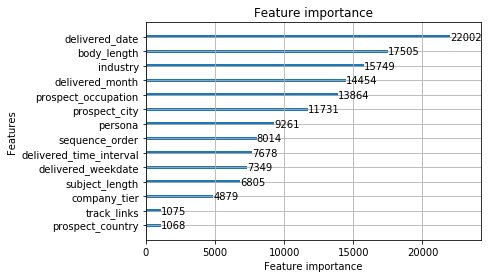

In [275]:
ax = lgb.plot_importance(gbm)
plt.show()

We can see that all the engineered features related to 'delivered_at' turn out to be important. The length of the email is also a key factor, likely because people tend to get lazy to read and reply to a long marketing email. Industry of the prospect seems to be crucial as well, suggesting that we might want to focus on only a few industry if we have limited resources.

# 4/ Statistical Analysis

In this section we will try to find important features in a more statistical way by using Lasso. We will also try to come up with the best setting for each feature, the task which is tricky to accomplish using Machine Learning models.

Since Lasso cannot handle missing values, I will create a new class for missing values in categorical features and impute missing values for numerical features using Scikit Imputer. 

In [81]:
# Save a copy of df before imputing
df2=df

In [43]:
# Handle categorical features
for col in cat+['track_links','track_opens']:
    df[col][df[col].isna()] = 'missing'

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [44]:
# Handle numerical features
from sklearn.preprocessing import Imputer
imputer = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)
imputer = imputer.fit(df.iloc[:, 4:6])   # For subject_length  and body_length
df.loc[:, 4:6] = imputer.transform(df.iloc[:, 4:6])

In [45]:
# We can verify that there are no more missing values 
df.isna().sum()

index                      0
is_thread_reply            0
subject_customized         0
body_customized            0
subject_length             0
body_length                0
track_links                0
track_opens                0
includes_link              0
prospect_occupation        0
prospect_city              0
prospect_country           0
persona                    0
industry                   0
company_tier               0
sequence_order             0
opened                     0
clicked                    0
replied                    0
delivered_time_interval    0
delivered_month            0
delivered_date             0
delivered_weekdate         0
success                    0
dtype: int64

In [50]:
# One-hot coding
df.delivered_time_interval = df.delivered_time_interval.apply(lambda x: str(x))
df.delivered_weekdate = df.delivered_weekdate.apply(lambda x: str(x))
dummy_df = pd.get_dummies(df)

Looking at the two numerical features, body_length and subject_length, one can realize that they have a quadratic effect on the success of an email. Intuitively, people are less likely to open and reply to an email that only has two words or have so many words in the title and body. We expect there will be a peak length at which we achieve the best success rate. Thus we will add the quadratic terms for these two features in our design matrix.

In [51]:
dummy_df['subject_length2'] = dummy_df['subject_length']*2
dummy_df['body_length2'] = dummy_df['body_length']*2

In [52]:
dummy_df.shape

(1023321, 3421)

We now have 3421 predictors, which is a lot but still manageable given our sample size. In this part, the focus is not model prediction but determining and understand important features. Therefore I will only do undersampling for the negative class then train Lasso without spliting into train and validation set.

In [53]:
# Undersampling for negative class
dummy_pos = dummy_df[dummy_df.success==1]
dummy_neg = dummy_df[dummy_df.success==0].sample(n=31139, random_state=1)
dummy_useddf = dummy_pos.append(dummy_neg)

In my opinion, fine-tuning around 50 different elements in the process is a good number. I think it will get difficult to try to manipulate more than that at one time. Therefore I chose the below level of regularization for Lasso to achive around 48 non-zero coefficients.

In [54]:
# Fit the Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
X_lasso = dummy_useddf.drop(columns=['index','opened','clicked','replied','success'])
y_lasso = dummy_useddf['success']
# Standardize the dataset
scaler = StandardScaler()
X_lasso= scaler.fit_transform(X_lasso)
X_lasso=pd.DataFrame(X_lasso,columns=dummy_useddf.drop(columns=['index','opened','clicked','replied','success']).columns)
# Fit
clf = LogisticRegression(random_state=0,C=0.002,penalty='l1',fit_intercept=False).fit(X_lasso,y_lasso)

In [72]:
len(np.where(abs(clf.coef_[0]-0)>0.001)[0])

42

One way to rank the importance of features kept by Lasso is by ranking the magnitude of the coefficients

In [73]:
# Getting non-zero coefficients
keep=np.where(abs(clf.coef_[0]-0)>0.001)
keep_name = X_lasso.columns[np.where(abs(clf.coef_[0]-0)>0.001)]
keep_coef = clf.coef_[0][np.where(abs(clf.coef_[0]-0)>0.001)]
sort_ind = np.argsort(abs(keep_coef))

In [74]:
# Overall ranking
keep_name[sort_ind][::-1]


Index(['sequence_order', 'persona_Not Assigned', 'body_length',
       'track_links_0.0', 'company_tier_Small Business', 'persona_Marketing',
       'delivered_month_1', 'subject_length', 'body_length2',
       'company_tier_Strategic', 'persona_Executive Leadership',
       'subject_length2', 'delivered_time_interval_1',
       'delivered_time_interval_6', 'persona_Sales Rep', 'industry_Internet',
       'persona_Sales Leadership', 'company_tier_Enterprise',
       'subject_customized', 'delivered_month_8', 'delivered_weekdate_1',
       'prospect_occupation_Medical Devices', 'persona_SDR',
       'delivered_time_interval_5', 'prospect_occupation_Biotechnology',
       'prospect_occupation_missing', 'prospect_occupation_Undefined',
       'persona_Sales Management', 'prospect_occupation_Internet',
       'industry_Information Technology and Services',
       'delivered_time_interval_4', 'delivered_time_interval_7',
       'delivered_month_2', 'prospect_city_San Francisco',
       'ind

These are the top 42 most important features reported by Lasso. However, we only care about the features that affect the positive class (successful email). To do this we need to look at the sign of the coefficients

In [75]:
features_lasso = pd.concat([pd.Series(keep_name[sort_ind][::-1]), pd.Series(keep_coef[sort_ind][::-1])], axis=1)
features_lasso

,0,1
0,sequence_order,-0.398145
1,persona_Not Assigned,0.291110
2,body_length,-0.243899
3,track_links_0.0,-0.156412
4,company_tier_Small Business,0.136110
5,persona_Marketing,-0.083952
6,delivered_month_1,0.083909
7,subject_length,0.080190
8,body_length2,-0.064652
9,company_tier_Strategic,-0.060656


The coefficients with positive sign are the ones that are helping, thus we should increase/use them. The ones with negative sign are the ones we should reduce/avoid. The underlying chosen features are pretty similar to the ones obtain by LightGBM in section 3, suggesting that these variables are strong indicators of whether an email will succeed. Some disimilarities are unavoidable since Gradient Boosting takes into account interactions while Lasso does not.

The optimal values for body_length and subject_length can be obtained by solving partial derivative equations and then unstandardize to get back original unit.

In [94]:
before_standardize = dummy_useddf.drop(columns=['index','opened','clicked','replied','success'])
opt_body_length = (-0.080190/0.051938 * before_standardize.body_length.std())+before_standardize.body_length.mean()
opt_body_length

1464.120834424216

In [90]:
opt_subject_length = (-0.080190/0.051938 * before_standardize.subject_length.std())+before_standardize.subject_length.mean()
opt_subject_length

62.12055184708131

# 5/ Business recommendations

In conclusion, these are my key recommendations:
    - The fewer emails sent before in the sequence, the more likely the email will succeed.
    - We should include link-tracking.
    - We should focus on Small Businesses and avoid companies with tiers Strategic and Enterprise if we have limited resources.
    - We should target Sales people, as opposed to Marketing teams and Executive positions.
    - We should consider sending out emails between 6am-9am, 3pm-6pm, 9pm-midnight since people are more likely to open and reply emails during these time.
    - People are more likely to open and reply to emails sent on weekend.
    - Emails with around 62 and 1464 characters in the title and body respectively seem to be the most effective ones.

# 6/ Potential next steps

If I have more time, I will do inferences for the coefficients chosen by Lasso, probably using the two-stage Lasso procedure, to have a more statistically reliable results. The dataset has a lot of missing values if somehow I can talk with the business team at Outreach, I will be able to understand more about those features I drop due to high missing-value proportion as well as the whole dataset in general. I believe my analysis will be improved greatly. Further tuning the LightGBM is also an option, although I doubt it will change the feature importance results. I believe our focus here is not heavy on predictions, rather on most importants feature that contribute to the success of an email. Accurate predictions are the by-product of that.